In [6]:
# this code is needed to ensure my working directory is the same as where the dataset is
import os
os.chdir('C:\\Users\\wyman\\Desktop\\701IntroProject\\INM701')

### Dataset Introduction

The dataset is 1,000,000 rows but a sample size of 10000 is used to save time. The ratio of fraud to non-fraud is increased significantly to help the model recognize fraud cases.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE, trustworthiness

df = pd.read_csv('data/card_transdata.csv')

# Get counts of fraud and non-fraud cases
fraud_count = df['fraud'].value_counts()
min_count = fraud_count.min()

# Separate fraud and non-fraud cases
fraud_df = df[df['fraud'] == 1].sample(n=5000, random_state=42)
non_fraud_df = df[df['fraud'] == 0].sample(n=5000, random_state=42)

# Combine the balanced datasets
df = pd.concat([fraud_df, non_fraud_df])

# Shuffle the final dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

### Standardization
This block normalizes the numeric features using StandardScaler to ensure that the Random Forest algorithm performs effectively. StandardScaler normalizes the data such that the Mean equals 0 and the Standard Deviation equals 1. The binary columns are left unchanged.

In [8]:
# separate features and labels
X = df.drop(columns=['fraud'], axis=1)  
y = df['fraud'] 

# separate binary columns
binary_columns = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]

# separate continuous columns
continuous_columns = [col for col in X.columns if col not in binary_columns]

# scale only the continuous columns
scaler = StandardScaler()
X_scaled_continuous = scaler.fit_transform(df[continuous_columns])

# combine binary and scaled continuous data
X_scaled = pd.concat(
    [pd.DataFrame(X_scaled_continuous, columns=continuous_columns), X[binary_columns].reset_index(drop=True)],
    axis=1
)

# check that the classification labels were split properly
print("\nValue Counts for Target Labels:")
print(y.value_counts())
print(f"Fraud ratio: {y.mean()}")


Value Counts for Target Labels:
fraud
0.0    5000
1.0    5000
Name: count, dtype: int64
Fraud ratio: 0.5


### Dimensionality Reduction Functions

In [9]:
def apply_pca(X, variance_threshold): # apply PCA dimension reduction to a given dataset
    pca = PCA(n_components=variance_threshold)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

def apply_tsne(X, perplexity, learning_rate=200): # apply t-SNE dimension reduction to a given dataset
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, learning_rate=learning_rate)
    X_tsne = tsne.fit_transform(X)
    return X_tsne, tsne

### Modeling Functions

In [22]:
def run_random_forest_cv(X, y, n_estimators, max_depth, cv=5, scoring='accuracy'):
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    results = cross_validate(rf, X, y, cv=cv, scoring=scoring)

    # use 'test_score' if scoring is a single metric
    if isinstance(scoring, str):
        mean_score = np.mean(results['test_score'])
        return {'accuracy': mean_score}
    else:
        # handle multi-metric scoring
        mean_scores = {f"test_{metric}": np.mean(results[f'test_{metric}']) for metric in scoring}
        return mean_scores

def grid_search_random_forest(X, y, n_estimators_range, max_depth_range, method_name="", scoring='accuracy', verbose=True):
    print(f"Grid Search for {method_name} ")
    print(f"n_estimators_range: {n_estimators_range}, max_depth_range: {max_depth_range}")

    # initialize a list to store all results
    all_results = []

    # loop through all combinations of hyperparameters
    for n_estimators in n_estimators_range:
        for depth in max_depth_range:
            # calculate scores for every combination
            score_dict = run_random_forest_cv(X, y, n_estimators, depth, cv=5, scoring=scoring)

            # extract the desired score (typically accuracy)
            displayed_score = score_dict[scoring] if isinstance(score_dict, dict) else score_dict

            # append the result as a dictionary
            result = {
                'Method': method_name,
                'n_estimators': n_estimators,
                'max_depth': depth if depth is not None else 'None',  # Handle None for plotting
                'Accuracy': displayed_score
            }
            all_results.append(result)

            if verbose:
                print(
                    f"{method_name} - n_estimators: {n_estimators}, max_depth: {depth}, "
                    f"Mean Accuracy: {displayed_score:.4f}"
                )

    # convert the list of results into a DataFrame
    return pd.DataFrame(all_results)

def run_dimensionality_reduction_and_cv(X, y, method=None, n_splits=5,
                                        n_estimators=None, max_depth=None,
                                        pca_threshold=None, tsne_perplexity=None):
    # apply corresponding dimension reduction
    if method == "PCA":
        print("Applying PCA")
        X_reduced, _ = apply_pca(X, pca_threshold)
    elif method == "TSNE":
        print("Applying t-SNE")
        X_reduced, _ = apply_tsne(X, tsne_perplexity)
    elif method is None:
        print("No dimensionality reduction")
        X_reduced = X

    X_reduced = np.array(X_reduced)
    y_np = np.array(y)

    # perform a stratifiedkfold for cv to split the data into validation sets while maintaining the original class distribution
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    print(f"\nRunning Cross-Validation ({'No Dimensionality Reduction' if method is None else method})")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_reduced, y)):
        print(f"Fold {fold + 1}/{n_splits}")
        X_train, X_val = X_reduced[train_idx], X_reduced[val_idx]
        y_train, y_val = y_np[train_idx], y_np[val_idx]

        # train rf for each fold
        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)

        # calculate performance metrics for each fold
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_val, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)
        fold_results.append((accuracy, precision, recall, f1))

        print(f"Fold Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    avg_metrics = np.mean(fold_results, axis=0)
    print(f"\nAverage Metrics Across Folds: Accuracy: {avg_metrics[0]:.4f}, Precision: {avg_metrics[1]:.4f}, Recall: {avg_metrics[2]:.4f}, F1-Score: {avg_metrics[3]:.4f}")
    return avg_metrics

def evaluate_on_test_set(X_train, y_train, X_test, y_test, method=None,
                         n_estimators=None, max_depth=None,
                         pca_threshold=None, tsne_perplexity=None):
    # apply the approriate dimension reduction if necessary
    if method == "PCA":
        X_train, pca_obj = apply_pca(X_train, pca_threshold)
        X_test = pca_obj.transform(X_test)
    elif method == "t-SNE":
        X_train, _ = apply_tsne(X_train, tsne_perplexity)
        X_test, _ = apply_tsne(X_test, tsne_perplexity)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # calculate and print performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

    print("Performance on Test Set:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return cm, X_test, y_pred, rf


### Graphing Functions

In [11]:
def plot_line_performance(x_values, y_values, title, xlabel, ylabel, labels=None):
    plt.figure(figsize=(10,6))
    if labels is None:
        labels = [None]*len(y_values)
    for y, lbl in zip(y_values, labels):
        plt.plot(x_values, y, marker='o', label=lbl)
    if any(labels):
        plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def plot_conf_matrix(cm, class_names=["Non-Fraud","Fraud"], title="Confusion Matrix"):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# plots accuracy vs number of estimators using data aggregated from all dimension reduction techniques
def plot_accuracy_vs_estimators(results_df):
    plt.figure(figsize=(10, 6))

    # group data by n_estimators and calculate mean accuracy
    grouped_data = results_df.groupby('n_estimators', as_index=False)['Accuracy'].mean()

    # plot the accuracy
    plt.plot(
        grouped_data['n_estimators'],  # x-axis
        grouped_data['Accuracy'],      # y-axis
        marker='o',
    )

    plt.title('Accuracy vs. Number of Estimators')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Mean Accuracy')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# plots accuracy vs number of estimators using data aggregated from all dimension reduction techniques
def plot_accuracy_vs_max_depth(results_df, placeholder_value):
    plt.figure(figsize=(10, 6))

    # replace invalid max_depth values ('None', None, NaN) with placeholder
    results_df['max_depth'] = results_df['max_depth'].replace(['None', None, np.nan], placeholder_value).astype(float)

    # group data by max_depth and calculate mean accuracy
    grouped_data = results_df.groupby('max_depth', as_index=False)['Accuracy'].mean()

    sorted_max_depth = sorted(grouped_data['max_depth'].unique())
    xticks_labels = [int(depth) if depth != placeholder_value else 'None' for depth in sorted_max_depth]

    # plot the accuracy
    plt.plot(
        grouped_data['max_depth'],  # x-axis
        grouped_data['Accuracy'],   # y-axis
        marker='o',
    )

    plt.title('Accuracy vs. Max Depth')
    plt.xlabel('Max Depth')
    plt.ylabel('Mean Accuracy')
    plt.grid(True)
    plt.xticks(ticks=sorted_max_depth, labels=xticks_labels)
    plt.tight_layout()
    plt.show()

### No Dimension Reduction Hyperparameter Refinement
A grid search is performed on the dataset without any dimension reduction, providing a baseline in how the model performs with minimal data preprocessing.

In [12]:
# define the range of hyperparameters for Random Forest (only used for no reduction)
n_estimators_range = [50, 100, 150, 200, 250]
max_depth_range = [None, 10, 20, 30]

# tune hyperparameters for the original data without dimensionality reduction
print("\nTuning hyperparameters for no reduction")
no_reduction_results = grid_search_random_forest(
    X_scaled, y, n_estimators_range, max_depth_range, method_name="No Reduction"
)

# store the best hyperparameters for no reduction
best_no_reduction_row = no_reduction_results.loc[no_reduction_results['Accuracy'].idxmax()]
best_n_estimators_no_reduction = best_no_reduction_row['n_estimators']
best_max_depth_no_reduction = None if best_no_reduction_row['max_depth'] == 'None' else best_no_reduction_row['max_depth']

# print and store the best results for each method
print("\nBest results for no reduction:")
print(f"Best n_estimators: {best_n_estimators_no_reduction}")
print(f"Best max_depth: {best_max_depth_no_reduction}")


Tuning hyperparameters for no reduction
Grid Search for No Reduction 
n_estimators_range: [50, 100, 150, 200, 250], max_depth_range: [None, 10, 20, 30]
No Reduction - n_estimators: 50, max_depth: None, Mean Accuracy: 0.9988
No Reduction - n_estimators: 50, max_depth: 10, Mean Accuracy: 0.9991
No Reduction - n_estimators: 50, max_depth: 20, Mean Accuracy: 0.9988
No Reduction - n_estimators: 50, max_depth: 30, Mean Accuracy: 0.9988
No Reduction - n_estimators: 100, max_depth: None, Mean Accuracy: 0.9992
No Reduction - n_estimators: 100, max_depth: 10, Mean Accuracy: 0.9992
No Reduction - n_estimators: 100, max_depth: 20, Mean Accuracy: 0.9991
No Reduction - n_estimators: 100, max_depth: 30, Mean Accuracy: 0.9992
No Reduction - n_estimators: 150, max_depth: None, Mean Accuracy: 0.9994
No Reduction - n_estimators: 150, max_depth: 10, Mean Accuracy: 0.9994
No Reduction - n_estimators: 150, max_depth: 20, Mean Accuracy: 0.9993
No Reduction - n_estimators: 150, max_depth: 30, Mean Accuracy: 

### PCA Optimization
PCA is run with various combinations of retained variance thresholds and hyperparameters to determine the optimal set of parameters for Random Forest with a PCA approach based primarily on the accuracy, which measures the proportion of correct predictions (both positive and negative) the model makes out of all predictions. The best combination of parameters is maintained for later testing.

In [13]:
# define PCA thresholds and RF hyperparameters
pca_thresholds = [0.70, 0.80, 0.90, 0.95, 0.99]
n_estimators_range = [50, 100, 150, 200, 250]
max_depth_range = [None, 10, 20, 30]

# create an empty DataFrame to store results
pca_rf_results = pd.DataFrame(columns=['pca_threshold', 'n_estimators', 'max_depth', 'Accuracy'])

# track original number of components
original_components = X_scaled.shape[1]

# loop through PCA thresholds and hyperparameter combinations
for pca_threshold in pca_thresholds:
    # apply PCA
    X_pca, pca_obj = apply_pca(X_scaled, pca_threshold)

    retained_components = pca_obj.n_components_
    removed_components = original_components - retained_components

    # perform grid search for Random Forest on PCA-reduced data
    rf_results_df = grid_search_random_forest(
        X_pca, y, n_estimators_range, max_depth_range, method_name=f"PCA (Threshold={pca_threshold})"
    )

    # add all results for this PCA threshold to the DataFrame
    rf_results_df['pca_threshold'] = pca_threshold
    pca_rf_results = pd.concat([pca_rf_results, rf_results_df], ignore_index=True)

# extract the best overall result based on accuracy
best_pca_result = pca_rf_results.loc[pca_rf_results['Accuracy'].idxmax()]

print("\nBest PCA Result:")
print(best_pca_result)


Grid Search for PCA (Threshold=0.7) 
n_estimators_range: [50, 100, 150, 200, 250], max_depth_range: [None, 10, 20, 30]
PCA (Threshold=0.7) - n_estimators: 50, max_depth: None, Mean Accuracy: 0.9528
PCA (Threshold=0.7) - n_estimators: 50, max_depth: 10, Mean Accuracy: 0.9532
PCA (Threshold=0.7) - n_estimators: 50, max_depth: 20, Mean Accuracy: 0.9531
PCA (Threshold=0.7) - n_estimators: 50, max_depth: 30, Mean Accuracy: 0.9529
PCA (Threshold=0.7) - n_estimators: 100, max_depth: None, Mean Accuracy: 0.9534
PCA (Threshold=0.7) - n_estimators: 100, max_depth: 10, Mean Accuracy: 0.9533
PCA (Threshold=0.7) - n_estimators: 100, max_depth: 20, Mean Accuracy: 0.9529
PCA (Threshold=0.7) - n_estimators: 100, max_depth: 30, Mean Accuracy: 0.9534
PCA (Threshold=0.7) - n_estimators: 150, max_depth: None, Mean Accuracy: 0.9538
PCA (Threshold=0.7) - n_estimators: 150, max_depth: 10, Mean Accuracy: 0.9531
PCA (Threshold=0.7) - n_estimators: 150, max_depth: 20, Mean Accuracy: 0.9540
PCA (Threshold=0.7) -

C:\Users\wyman\AppData\Local\Temp\ipykernel_22240\2237716774.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pca_rf_results = pd.concat([pca_rf_results, rf_results_df], ignore_index=True)


PCA (Threshold=0.8) - n_estimators: 50, max_depth: None, Mean Accuracy: 0.9528
PCA (Threshold=0.8) - n_estimators: 50, max_depth: 10, Mean Accuracy: 0.9532
PCA (Threshold=0.8) - n_estimators: 50, max_depth: 20, Mean Accuracy: 0.9531
PCA (Threshold=0.8) - n_estimators: 50, max_depth: 30, Mean Accuracy: 0.9529
PCA (Threshold=0.8) - n_estimators: 100, max_depth: None, Mean Accuracy: 0.9534
PCA (Threshold=0.8) - n_estimators: 100, max_depth: 10, Mean Accuracy: 0.9533
PCA (Threshold=0.8) - n_estimators: 100, max_depth: 20, Mean Accuracy: 0.9529
PCA (Threshold=0.8) - n_estimators: 100, max_depth: 30, Mean Accuracy: 0.9534
PCA (Threshold=0.8) - n_estimators: 150, max_depth: None, Mean Accuracy: 0.9538
PCA (Threshold=0.8) - n_estimators: 150, max_depth: 10, Mean Accuracy: 0.9531
PCA (Threshold=0.8) - n_estimators: 150, max_depth: 20, Mean Accuracy: 0.9540
PCA (Threshold=0.8) - n_estimators: 150, max_depth: 30, Mean Accuracy: 0.9537
PCA (Threshold=0.8) - n_estimators: 200, max_depth: None, Mean

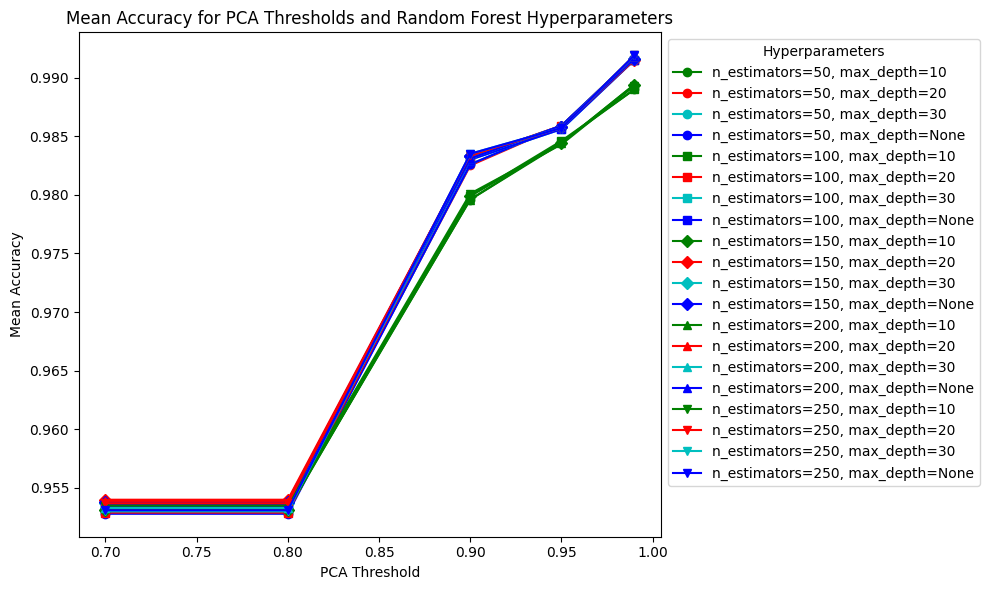

In [14]:
# define unique markers and colors to help identify trends
markers = ['o', 's', 'D', '^', 'v']  # markers for different n_estimator amounts
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # colors for each max_depth value

plt.figure(figsize=(10, 6))

# create a mapping for consistent markers and colors
n_estimators_to_marker = {n: markers[i % len(markers)] for i, n in enumerate(pca_rf_results['n_estimators'].unique())}
max_depth_range_with_none = pca_rf_results['max_depth'].unique().tolist()
max_depth_to_color = {d: colors[i % len(colors)] for i, d in enumerate(max_depth_range_with_none)}

# group data by n_estimators and max_depth, and plot
for (n_estimators, max_depth), group in pca_rf_results.groupby(['n_estimators', 'max_depth']):
    label = f'n_estimators={n_estimators}, max_depth={"None" if max_depth is None else max_depth}'
    plt.plot(
        group['pca_threshold'],  # x-axis
        group['Accuracy'],       # y-axis
        marker=n_estimators_to_marker[n_estimators],
        color=max_depth_to_color[max_depth],
        label=label
    )

plt.title("Mean Accuracy for PCA Thresholds and Random Forest Hyperparameters")
plt.xlabel("PCA Threshold")
plt.ylabel("Mean Accuracy")
plt.legend(title="Hyperparameters", loc='upper left', bbox_to_anchor=(1, 1)) 
plt.tight_layout()
plt.show()


The number of estimators or depth did not seem to have a real effect on the mean accuracy compared to increasing the PCA threshold. The mean accuracy is already very high so applying PCA do the dataset could be redundant or remove meaningful information for no reason.

### t-SNE Optimization
t-SNE is run with various combinations of perplexities and hyperparameters to determine the optimal set of parameters for Random Forest with a t-SNE approach based primarily on the silhouette score and the ARI. The trustworthiness is useful to verify that the local structure of the data is properly reflected after the dimension reduction, which is important for visualization, but the other metrics better measure how well the data is preservered after being reduced. 

In [15]:
# define t-SNE perplexities and RF hyperparameters
tsne_perplexities = [5, 10, 20, 30, 40]
n_estimators_range = [50, 100, 150, 200, 250]
max_depth_range = [None, 10, 20, 30]

# create an empty DataFrame to store results
tsne_rf_results = pd.DataFrame(columns=['tsne_perplexity', 'n_estimators', 'max_depth', 'Accuracy', 'Trustworthiness'])

# loop through t-SNE perplexities and RF hyperparameter combinations
for perplexity in tsne_perplexities:
    # apply t-SNE
    X_tsne, tsne_obj = apply_tsne(X_scaled, perplexity)
    trust = trustworthiness(X_scaled, X_tsne, n_neighbors=5)

    # perform grid search for Random Forest on t-SNE-reduced data
    rf_results_df = grid_search_random_forest(
        X_tsne, y, n_estimators_range, max_depth_range, method_name=f"t-SNE (Perplexity={perplexity})"
    )

    # add all results for this t-SNE perplexity to the DataFrame
    rf_results_df['tsne_perplexity'] = perplexity
    rf_results_df['Trustworthiness'] = trust
    tsne_rf_results = pd.concat([tsne_rf_results, rf_results_df], ignore_index=True)

# extract the best overall result based on accuracy
best_tsne_result = tsne_rf_results.loc[tsne_rf_results['Accuracy'].idxmax()]

print("\nBest t-SNE Result:")
print(best_tsne_result)


Grid Search for t-SNE (Perplexity=5) 
n_estimators_range: [50, 100, 150, 200, 250], max_depth_range: [None, 10, 20, 30]
t-SNE (Perplexity=5) - n_estimators: 50, max_depth: None, Mean Accuracy: 0.9897
t-SNE (Perplexity=5) - n_estimators: 50, max_depth: 10, Mean Accuracy: 0.9875
t-SNE (Perplexity=5) - n_estimators: 50, max_depth: 20, Mean Accuracy: 0.9897
t-SNE (Perplexity=5) - n_estimators: 50, max_depth: 30, Mean Accuracy: 0.9897
t-SNE (Perplexity=5) - n_estimators: 100, max_depth: None, Mean Accuracy: 0.9900
t-SNE (Perplexity=5) - n_estimators: 100, max_depth: 10, Mean Accuracy: 0.9877
t-SNE (Perplexity=5) - n_estimators: 100, max_depth: 20, Mean Accuracy: 0.9900
t-SNE (Perplexity=5) - n_estimators: 100, max_depth: 30, Mean Accuracy: 0.9900
t-SNE (Perplexity=5) - n_estimators: 150, max_depth: None, Mean Accuracy: 0.9898
t-SNE (Perplexity=5) - n_estimators: 150, max_depth: 10, Mean Accuracy: 0.9882
t-SNE (Perplexity=5) - n_estimators: 150, max_depth: 20, Mean Accuracy: 0.9898
t-SNE (Pe

C:\Users\wyman\AppData\Local\Temp\ipykernel_22240\116963144.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tsne_rf_results = pd.concat([tsne_rf_results, rf_results_df], ignore_index=True)


Grid Search for t-SNE (Perplexity=10) 
n_estimators_range: [50, 100, 150, 200, 250], max_depth_range: [None, 10, 20, 30]
t-SNE (Perplexity=10) - n_estimators: 50, max_depth: None, Mean Accuracy: 0.9892
t-SNE (Perplexity=10) - n_estimators: 50, max_depth: 10, Mean Accuracy: 0.9860
t-SNE (Perplexity=10) - n_estimators: 50, max_depth: 20, Mean Accuracy: 0.9892
t-SNE (Perplexity=10) - n_estimators: 50, max_depth: 30, Mean Accuracy: 0.9892
t-SNE (Perplexity=10) - n_estimators: 100, max_depth: None, Mean Accuracy: 0.9888
t-SNE (Perplexity=10) - n_estimators: 100, max_depth: 10, Mean Accuracy: 0.9866
t-SNE (Perplexity=10) - n_estimators: 100, max_depth: 20, Mean Accuracy: 0.9888
t-SNE (Perplexity=10) - n_estimators: 100, max_depth: 30, Mean Accuracy: 0.9888
t-SNE (Perplexity=10) - n_estimators: 150, max_depth: None, Mean Accuracy: 0.9894
t-SNE (Perplexity=10) - n_estimators: 150, max_depth: 10, Mean Accuracy: 0.9864
t-SNE (Perplexity=10) - n_estimators: 150, max_depth: 20, Mean Accuracy: 0.98

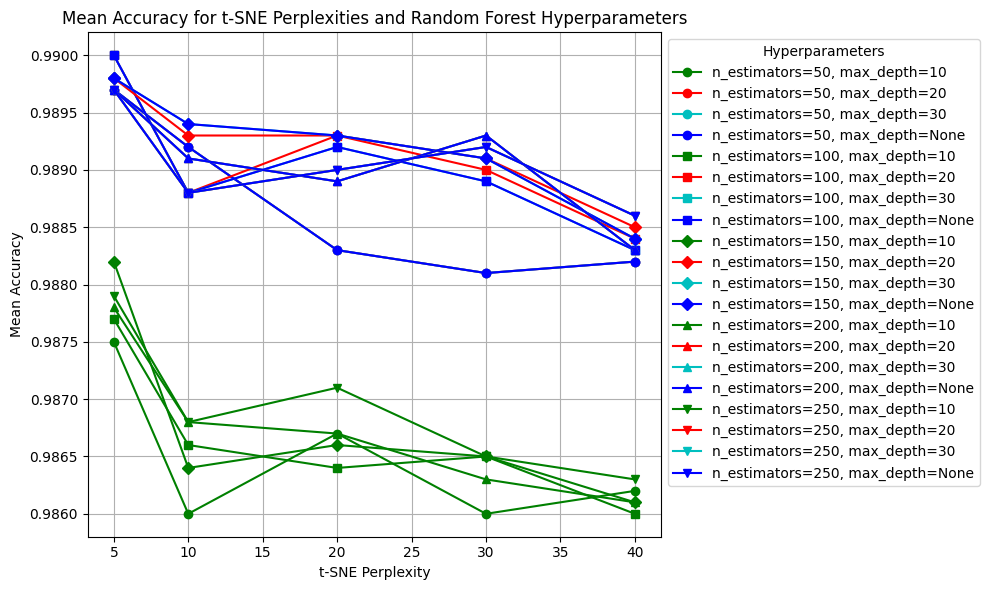

In [16]:
# define unique markers and colors to help identify trends
markers = ['o', 's', 'D', '^', 'v']  # markers for different n_estimators
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # colors for different max_depth values

plt.figure(figsize=(10, 6))

# create a mapping for consistent markers and colors
n_estimators_to_marker = {n: markers[i % len(markers)] for i, n in enumerate(tsne_rf_results['n_estimators'].unique())}
max_depth_range_with_none = tsne_rf_results['max_depth'].unique().tolist()
max_depth_to_color = {d: colors[i % len(colors)] for i, d in enumerate(max_depth_range_with_none)}

for (n_estimators, max_depth), group in tsne_rf_results.groupby(['n_estimators', 'max_depth']):
    label = f'n_estimators={n_estimators}, max_depth={"None" if max_depth is None else max_depth}'
    
    plt.plot(
        group['tsne_perplexity'],  # x-axis
        group['Accuracy'],         # y-axis
        marker=n_estimators_to_marker[n_estimators],
        color=max_depth_to_color[max_depth],
        label=label
    )

plt.title("Mean Accuracy for t-SNE Perplexities and Random Forest Hyperparameters")
plt.xlabel("t-SNE Perplexity")
plt.ylabel("Mean Accuracy")
plt.legend(title="Hyperparameters", loc='upper left', bbox_to_anchor=(1, 1)) 
plt.grid()
plt.tight_layout()
plt.show()


On average, accuracy seems to slightly decrease as you increase the t-SNE perplexities. This could be because higher perplexities causes t-SNE to focus on larger structures of data, which can smooth out differences between points and lead to a loss of information. It also seems that raising the amount of depth increases the accuracy across any amount of estimators. This is likely because more depth allows the algorithm to capture complex patterns.

### Final Trained Parameters
This block aggregates the best hyperparameters for each dataset and prints them to summarize information.

In [17]:
# extract and store the best hyperparameters for No Reduction
print("\nFinding best hyperparameters for No Reduction")
best_no_reduction_row = no_reduction_results.loc[no_reduction_results['Accuracy'].idxmax()]
best_n_estimators_no_reduction = best_no_reduction_row['n_estimators']
best_max_depth_no_reduction = None if best_no_reduction_row['max_depth'] in ['None', None] else best_no_reduction_row['max_depth']

# extract and store the best hyperparameters for PCA
print("\nFinding best hyperparameters for PCA")
best_pca_threshold = best_pca_result.iloc[0]
X_pca_best, _ = apply_pca(X_scaled, best_pca_threshold)
best_n_estimators_pca = best_pca_result.iloc[1]  
best_max_depth_pca = None if best_pca_result.iloc[2] in ['None', None] else best_pca_result.iloc[2]

# extract and store the best hyperparameters for t-SNE
print("\nFinding best hyperparameters for t-SNE")
best_tsne_perplexity = best_tsne_result.iloc[0]
X_tsne_best, _ = apply_tsne(X_scaled, best_tsne_perplexity)
best_n_estimators_tsne = best_tsne_result.iloc[1]  
best_max_depth_tsne = None if best_tsne_result.iloc[2] in ['None', None] else best_tsne_result.iloc[2]

# print for each method
print("\nBest results for No Reduction:")
print(f"Best n_estimators: {best_n_estimators_no_reduction}")
print(f"Best max_depth: {best_max_depth_no_reduction}")

print("\nBest results for PCA:")
print(f"Best PCA Threshold: {best_pca_threshold}")
print(f"Best n_estimators: {best_n_estimators_pca}")
print(f"Best max_depth: {best_max_depth_pca}")

print("\nBest results for t-SNE:")
print(f"Best t-SNE Perplexity: {best_tsne_perplexity}")
print(f"Best n_estimators: {best_n_estimators_tsne}")
print(f"Best max_depth: {best_max_depth_tsne}")



Finding best hyperparameters for No Reduction

Finding best hyperparameters for PCA

Finding best hyperparameters for t-SNE

Best results for No Reduction:
Best n_estimators: 150
Best max_depth: None

Best results for PCA:
Best PCA Threshold: 0.99
Best n_estimators: 250
Best max_depth: None

Best results for t-SNE:
Best t-SNE Perplexity: 5
Best n_estimators: 100
Best max_depth: None


### Hyperparameter Refinement Visualization
This block aggregates the data from all of the different dimension reduction possibilities to look for overall trends in estimators and max depth compared to accuracy.


Plotting Accuracy vs. Number of Estimators


C:\Users\wyman\AppData\Local\Temp\ipykernel_22240\4071961081.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(['None', None], np.nan)
C:\Users\wyman\AppData\Local\Temp\ipykernel_22240\4071961081.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(['None', None], np.nan)
C:\Users\wyman\AppData\Local\Temp\ipykernel_22240\4071961081.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=

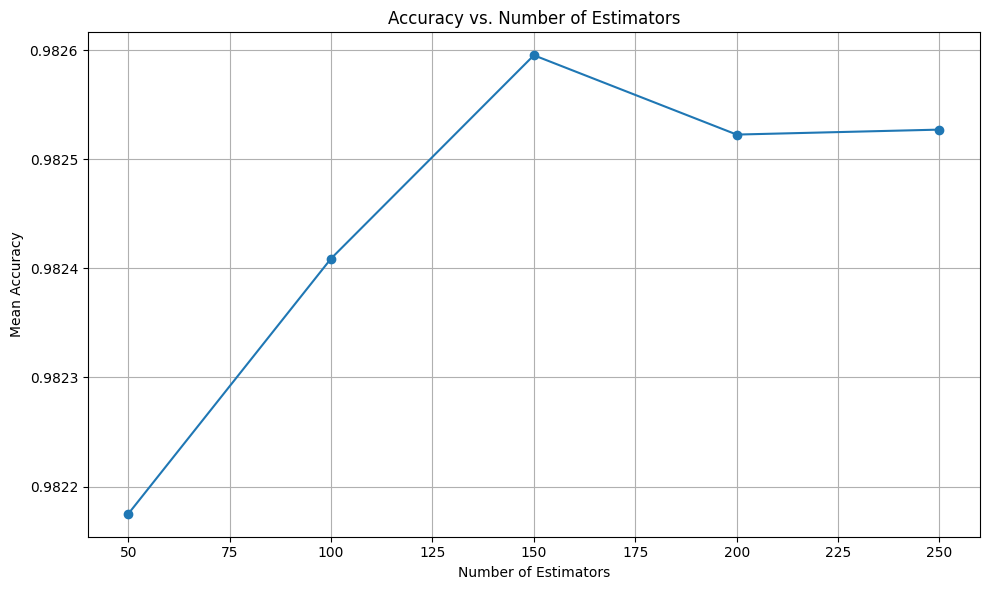


Plotting Accuracy vs. Max Depth


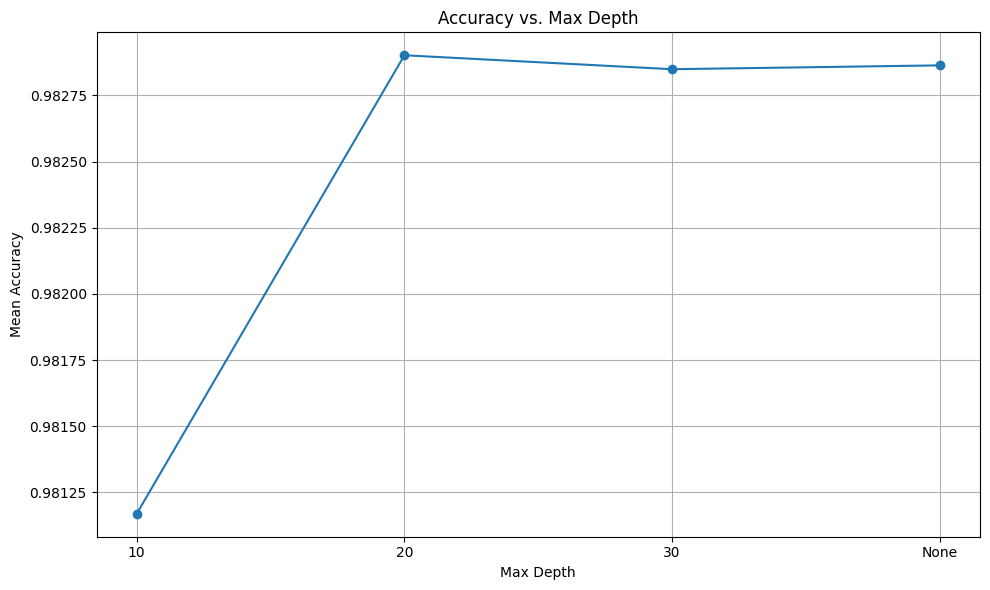

In [18]:
# ensure max_depth values are consistently None where applicable
no_reduction_results['max_depth'] = (
    no_reduction_results['max_depth']
    .replace(['None', None], np.nan)
    .infer_objects()
    .astype(float)
)

pca_rf_results['max_depth'] = (
    pca_rf_results['max_depth']
    .replace(['None', None], np.nan)
    .infer_objects()
    .astype(float)
)

tsne_rf_results['max_depth'] = (
    tsne_rf_results['max_depth']
    .replace(['None', None], np.nan)
    .infer_objects()
    .astype(float)
)

# combine DataFrames to compare the aggregated data
combined_results_df = pd.concat([no_reduction_results, pca_rf_results, tsne_rf_results], ignore_index=True)

# placeholder for None in max_depth for integer comparisons
valid_max_depth = [d for d in max_depth_range if d is not None]
placeholder_value = max(valid_max_depth) + 10

print("\nPlotting Accuracy vs. Number of Estimators")
plot_accuracy_vs_estimators(combined_results_df)

print("\nPlotting Accuracy vs. Max Depth")
plot_accuracy_vs_max_depth(combined_results_df, placeholder_value)


These graphs confirm past observations that accuracy consistently increases as you increaese depth or the number of estimators, although it does plataeu at around 20 max depth and 150 estimators.

### Cross Validation
This block runs cross validation using either PCA, t-SNE, or no dimension reduction with optimal hyperparameters and compares the metrics of the outcomes to ensure each model is trained correctly.

No dimensionality reduction

Running Cross-Validation (No Dimensionality Reduction)
Fold 1/5
Fold Metrics - Accuracy: 0.9995, Precision: 0.9990, Recall: 1.0000, F1-Score: 0.9995
Fold 2/5
Fold Metrics - Accuracy: 0.9980, Precision: 0.9960, Recall: 1.0000, F1-Score: 0.9980
Fold 3/5
Fold Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
Fold 4/5
Fold Metrics - Accuracy: 0.9995, Precision: 0.9990, Recall: 1.0000, F1-Score: 0.9995
Fold 5/5
Fold Metrics - Accuracy: 0.9990, Precision: 0.9980, Recall: 1.0000, F1-Score: 0.9990

Average Metrics Across Folds: Accuracy: 0.9992, Precision: 0.9984, Recall: 1.0000, F1-Score: 0.9992
Applying PCA

Running Cross-Validation (PCA)
Fold 1/5
Fold Metrics - Accuracy: 0.9930, Precision: 0.9891, Recall: 0.9970, F1-Score: 0.9930
Fold 2/5
Fold Metrics - Accuracy: 0.9925, Precision: 0.9871, Recall: 0.9980, F1-Score: 0.9925
Fold 3/5
Fold Metrics - Accuracy: 0.9890, Precision: 0.9832, Recall: 0.9950, F1-Score: 0.9891
Fold 4/5
Fold Metr

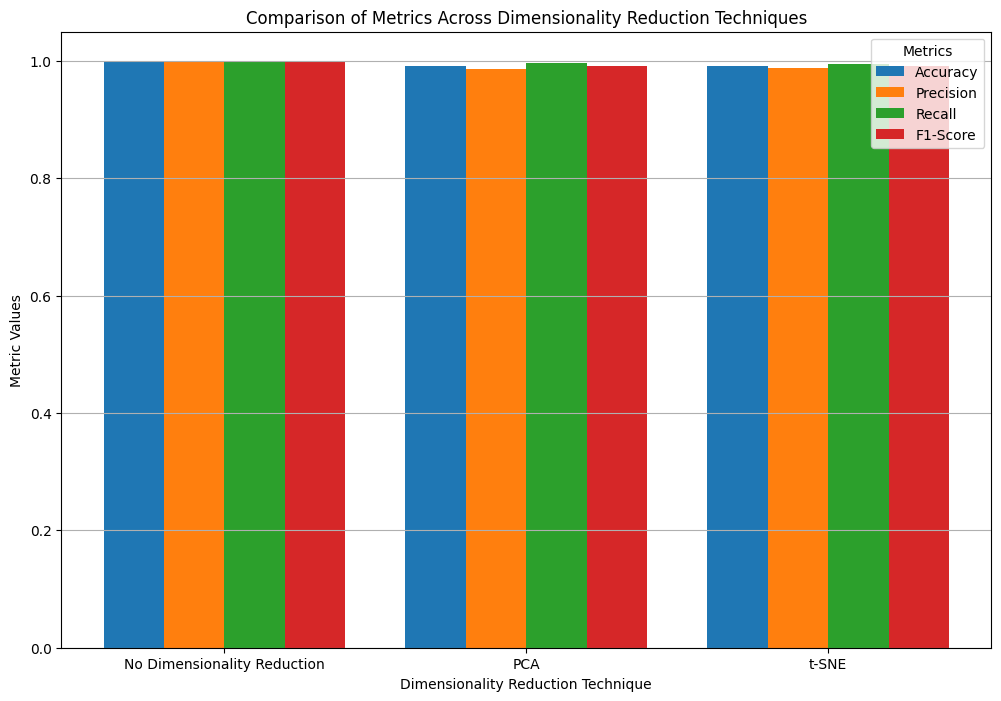

In [19]:
# run for no dimensionality reduction
metrics_no_reduction = run_dimensionality_reduction_and_cv(
    X_scaled, y, method=None,
    n_estimators=best_n_estimators_no_reduction, max_depth=best_max_depth_no_reduction
)

# run for pca using the best hyperparameters
metrics_pca = run_dimensionality_reduction_and_cv(
    X_scaled, y, method="PCA",
    n_estimators=best_n_estimators_pca, max_depth=best_max_depth_pca, pca_threshold=best_pca_threshold
)

# run for t-sne using the best hyperparameters
metrics_tsne = run_dimensionality_reduction_and_cv(
    X_scaled, y, method="TSNE",
    n_estimators=best_n_estimators_tsne, max_depth=best_max_depth_tsne, tsne_perplexity=best_tsne_perplexity
)

# collect metrics for plotting
methods = ["No Dimensionality Reduction", "PCA", "t-SNE"]
metrics_labels = ["Accuracy", "Precision", "Recall", "F1-Score"]

# create list to store metrics
metrics_list = [metrics_no_reduction, metrics_pca, metrics_tsne]

# convert metrics_list to a NumPy array for easy indexing
scores = np.array(metrics_list)

# define data and labels
x = np.arange(len(methods))
width = 0.2  

plt.figure(figsize=(12, 8))
for i, metric_label in enumerate(metrics_labels):
    plt.bar(x + i * width, scores[:, i], width, label=metric_label)

plt.title("Comparison of Metrics Across Dimensionality Reduction Techniques")
plt.ylabel("Metric Values")
plt.xlabel("Dimensionality Reduction Technique")
plt.xticks(x + width * 1.5, methods)
plt.legend(title="Metrics")
plt.grid(axis='y')
plt.show()



After running CV to compare the different reduction techniques, the model performs extremely well regardless of which approach is chosen. However, the unreduced dataset performs slightly better than the datasets with their dimensions reduced. This might be because the reduction is removing important information and the model is able to handle the extra noise well.

### Test Set Evaluation
The following block evaluates the test set after it has been trained on models using data altered by either PCA, t-SNE, or no dimension reduction.

Performance on Test Set:
Accuracy: 0.9997
Precision: 1.0000
Recall: 0.9993
F1-Score: 0.9997


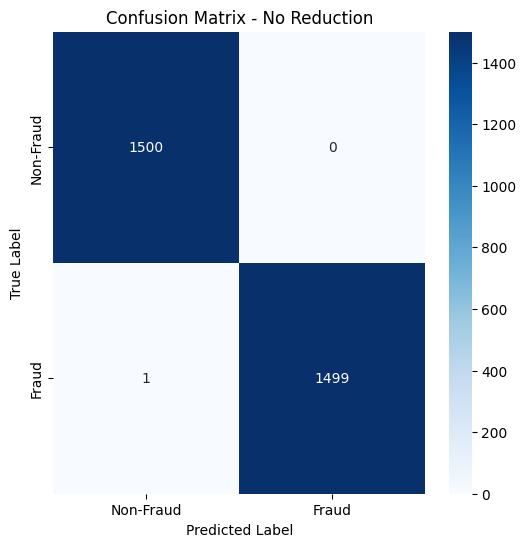

Performance on Test Set:
Accuracy: 0.9900
Precision: 0.9836
Recall: 0.9967
F1-Score: 0.9901


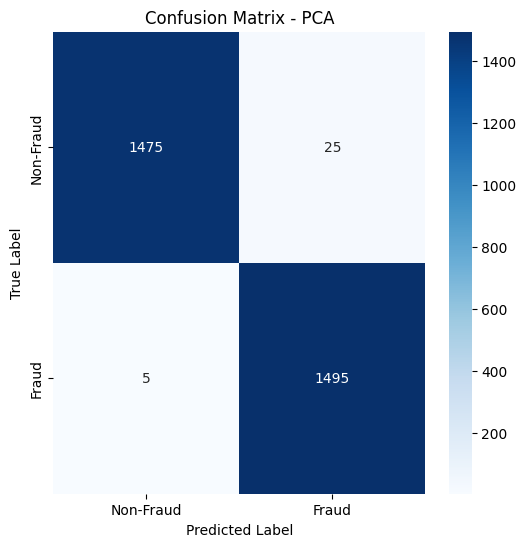

Performance on Test Set:
Accuracy: 0.6760
Precision: 0.6811
Recall: 0.6620
F1-Score: 0.6714


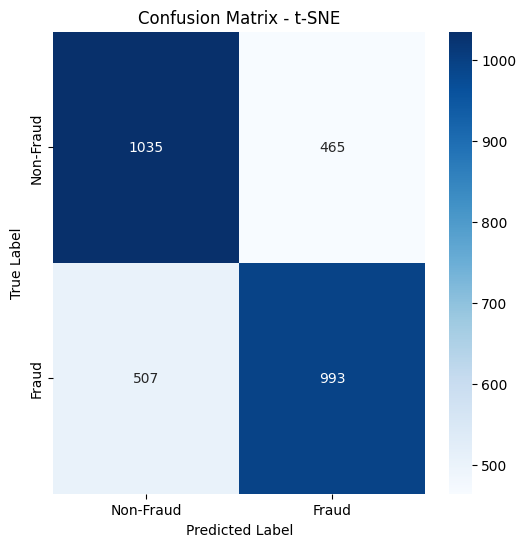

In [23]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# evaluate No Reduction and plot the confusion matrix
cm_no_red, _, _, rf_no_red = evaluate_on_test_set(
    X_train, y_train, X_test, y_test, method=None,
    n_estimators=best_n_estimators_no_reduction, max_depth=best_max_depth_no_reduction
)
plot_conf_matrix(cm_no_red, title="Confusion Matrix - No Reduction")

# evaluate PCA and plot the confusion matrix
cm_pca, X_test_pca, y_pred_pca, rf_pca = evaluate_on_test_set(
    X_train, y_train, X_test, y_test, method="PCA",
    n_estimators=best_n_estimators_pca, max_depth=best_max_depth_pca,
    pca_threshold=best_pca_threshold
)
plot_conf_matrix(cm_pca, title="Confusion Matrix - PCA")

# evaluate t-SNE and plot the confusion matrix
cm_tsne, X_test_tsne, y_pred_tsne, rf_tsne = evaluate_on_test_set(
    X_train, y_train, X_test, y_test, method="t-SNE",
    n_estimators=best_n_estimators_tsne, max_depth=best_max_depth_tsne,
    tsne_perplexity=best_tsne_perplexity
)
plot_conf_matrix(cm_tsne, title="Confusion Matrix - t-SNE")


The dataset with no dimensionality reduction performed slightly better than the PCA reduced dataset, but both of these datasets were very reliable and had high rates of true positives and true negatives. Dimension reduction with t-SNE offered a substantial decrease in performance, identifiying many more false positives and false negatives. t-SNE is more focused on data visualization rather than improving the rate of classification. One problem with t-SNE is that it always reduces to 2 dimensions which could lead to a large loss of relevent information and a less accurate model. 